In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
from utils import plot_psd, psd, read_iq, welch, read_iq, welch

Da Nang experiments:
 1. got data from GQRX - weird offset, failed
 2. got data from rtl_sdr - no offset but super low quality, shitty spectrum - due to DC spike??

I don't understand:
 - why GQRX raw data looks like shit - it's not symmetrical at all, were there 2 stations just 200kHz apart? I doubt that, but maybe? I could demodulate both bands and see if they differ!
 - is that due to incorrect read of inputs, i.e. int not float?

### How to demodulate FM (example)
1. Input sampling rate 2.4 MHz (top frequency content- LPF to 120 kHz and decimate by 10.
2. Demodulate - calculate derivative of signal phase
  - use atan2 and diff
  - use atan derivative formula 
3. Scale the signal (float requires `[-1, 1]` for example).  
4. LPF to 24 kHz and decimate by 5.

### Notes
1. Looks like low SNR - like 15dB from Welch below? I had 40dB in my earlier experiments. Also lab 6 mentions 43.4 dB SNR for quantization noise like "this may seem low" lol.

In [3]:
def fm_demod_1(iq_samples):
  return np.angle(iq_samples[1:] * np.conj(iq_samples[:-1]))
  

def fm_demod_2(iq_samples):
  xq, xi = np.imag(iq_samples), np.real(iq_samples)
  d_xq, d_xi = np.diff(xq, prepend=xq[0]), np.diff(xi, prepend=xi[0])
  return (xi * d_xq - xq * d_xi) / (xq ** 2 + xi ** 2)


def demodulate(iq_samples, demod=fm_demod_1):
  dec_iq_samples = signal.decimate(iq_samples, 10)
  demod = demod(dec_iq_samples)
  demod_dec = signal.decimate(demod, 5)
  return demod_dec / np.abs(demod_dec).max()

In [4]:
def read_iq_float(f_name):
    real_sample = np.fromfile(f_name, dtype=np.float32)
    return real_sample[::2] + 1j * real_sample[1::2]
iq_samples = read_iq_float('data/102_7.raw')

/home/jakub/projects/SDR/SDR/env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


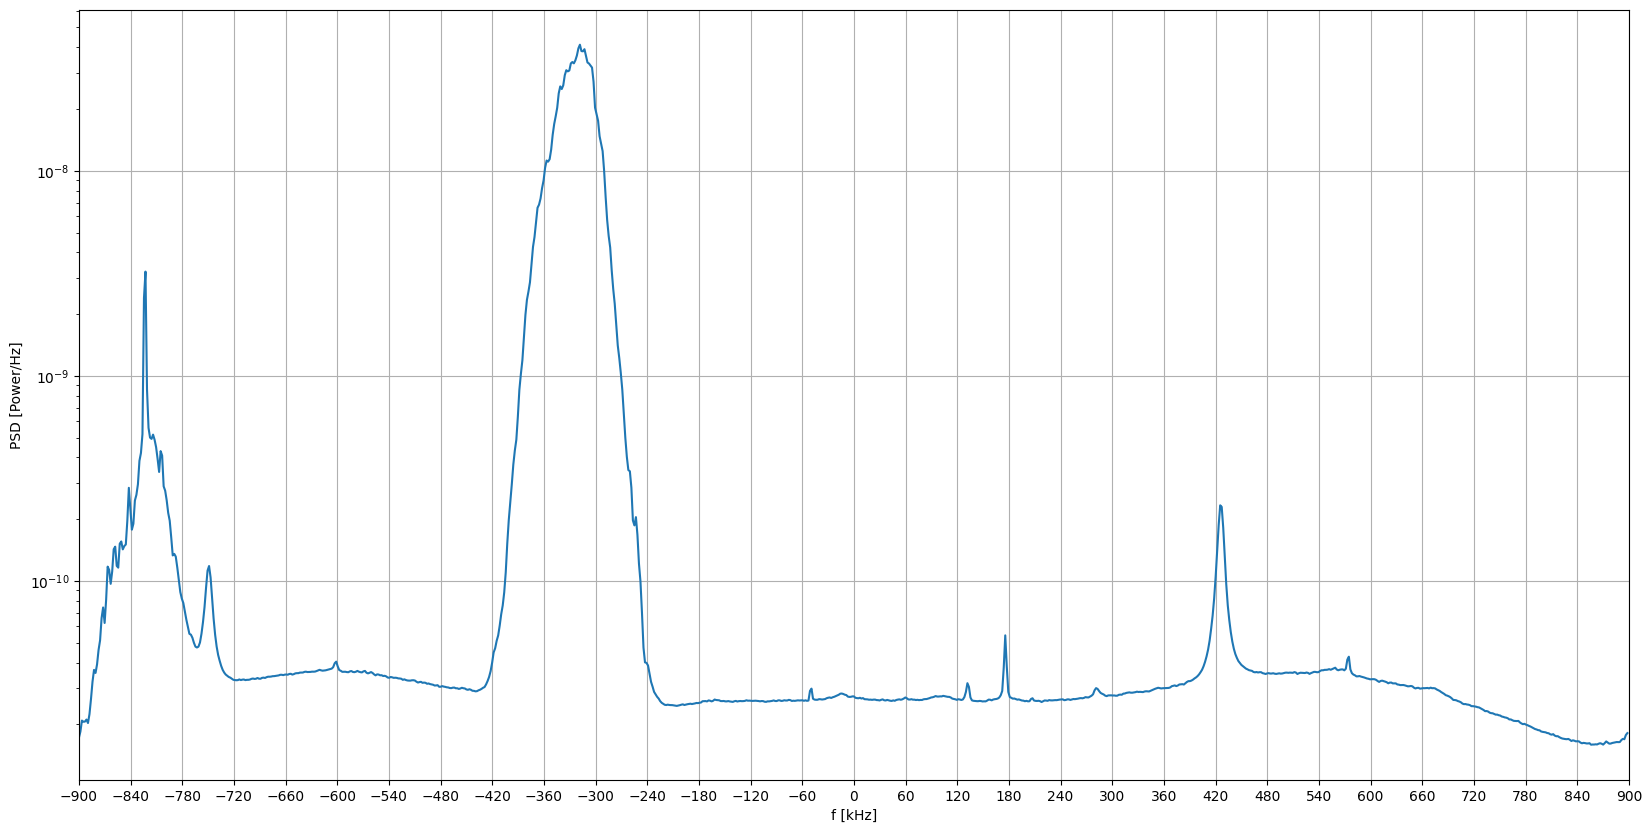

In [5]:
sample_rate = 1800000
welch(iq_samples, sample_rate)

In [6]:
offset = 320000
t_s = np.linspace(0, len(iq_samples) / sample_rate, len(iq_samples))
iq_samples_centered = iq_samples * np.exp(2 * np.pi * offset * t_s * 1j)

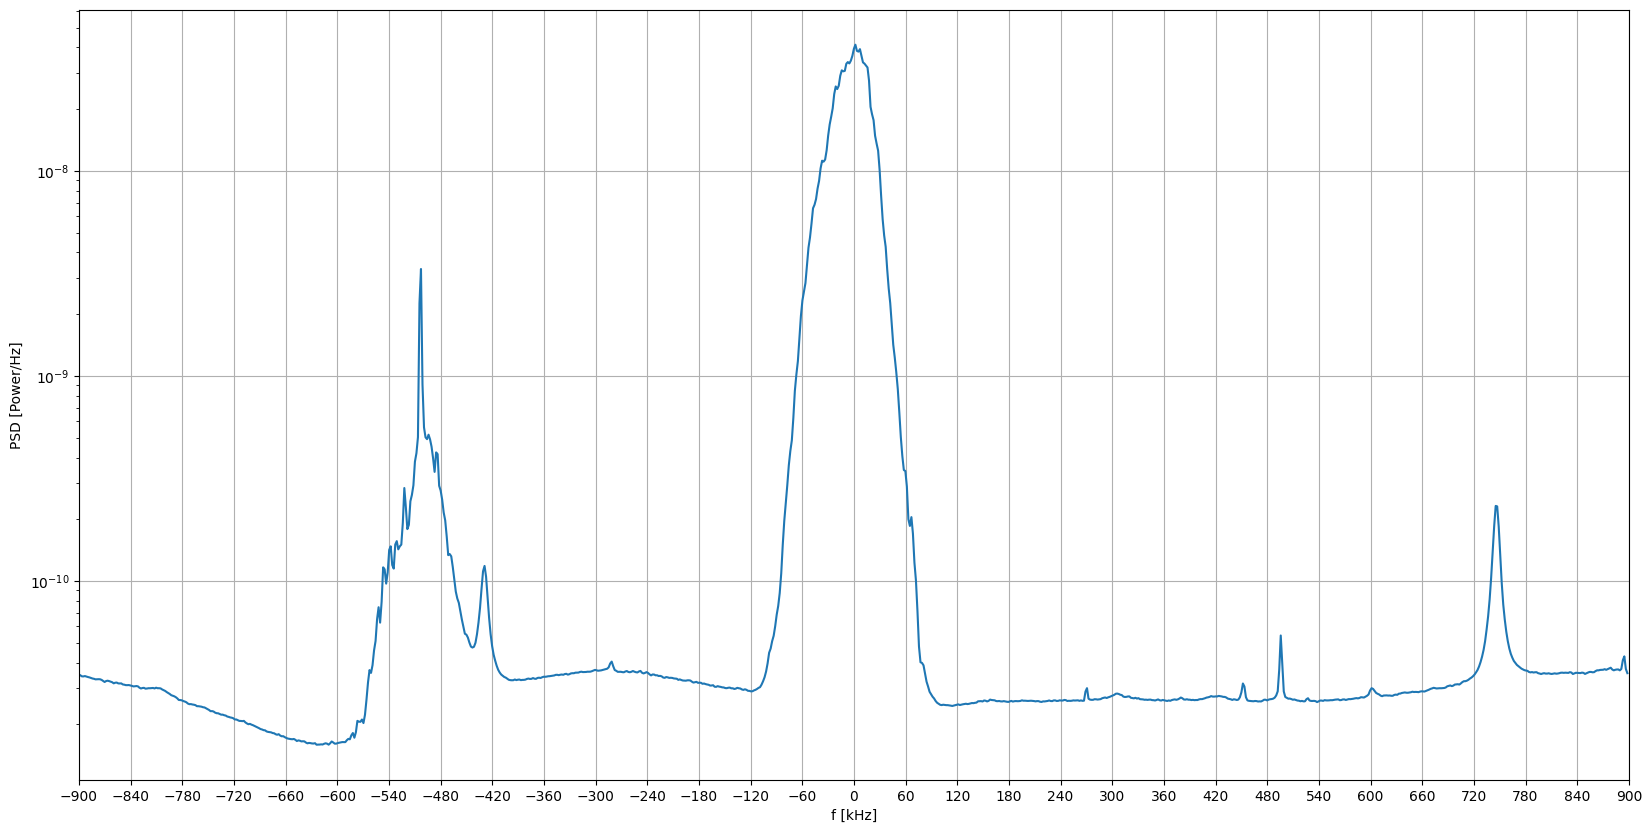

In [7]:
welch(iq_samples_centered, sample_rate)

In [8]:
from scipy.signal import decimate
dec_iq_samples = decimate(iq_samples_centered, 5)
n_rate = sample_rate / 5

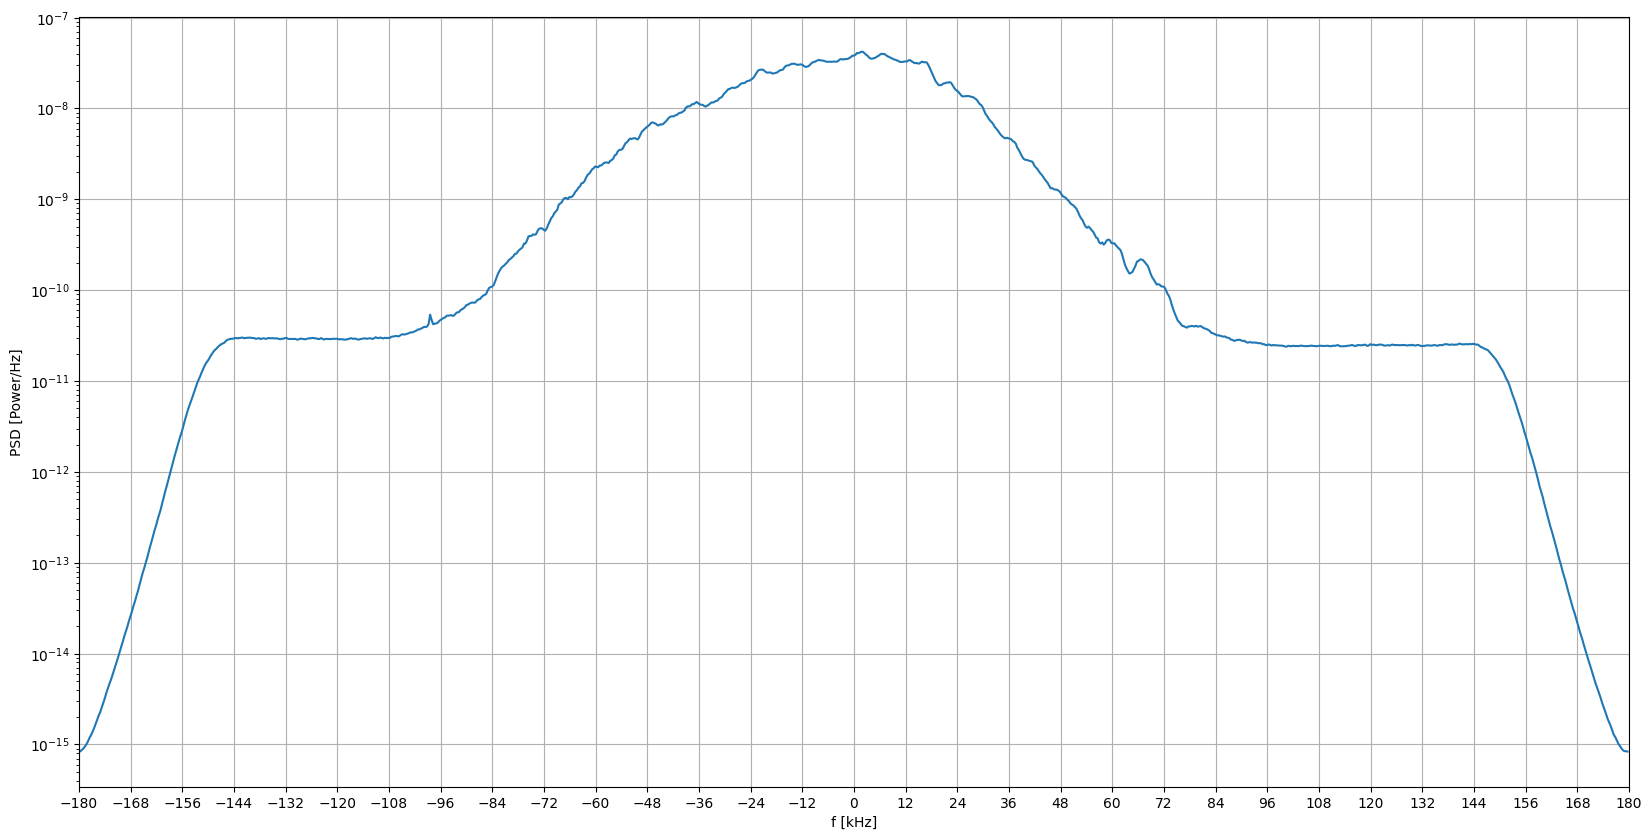

In [9]:
welch(dec_iq_samples, n_rate)

### Phase derivative (diff) with conjugate multiplication
Maybe avoids wrapping?

In [10]:
phase_diff = np.angle(dec_iq_samples[1:] * np.conj(dec_iq_samples[:-1]))

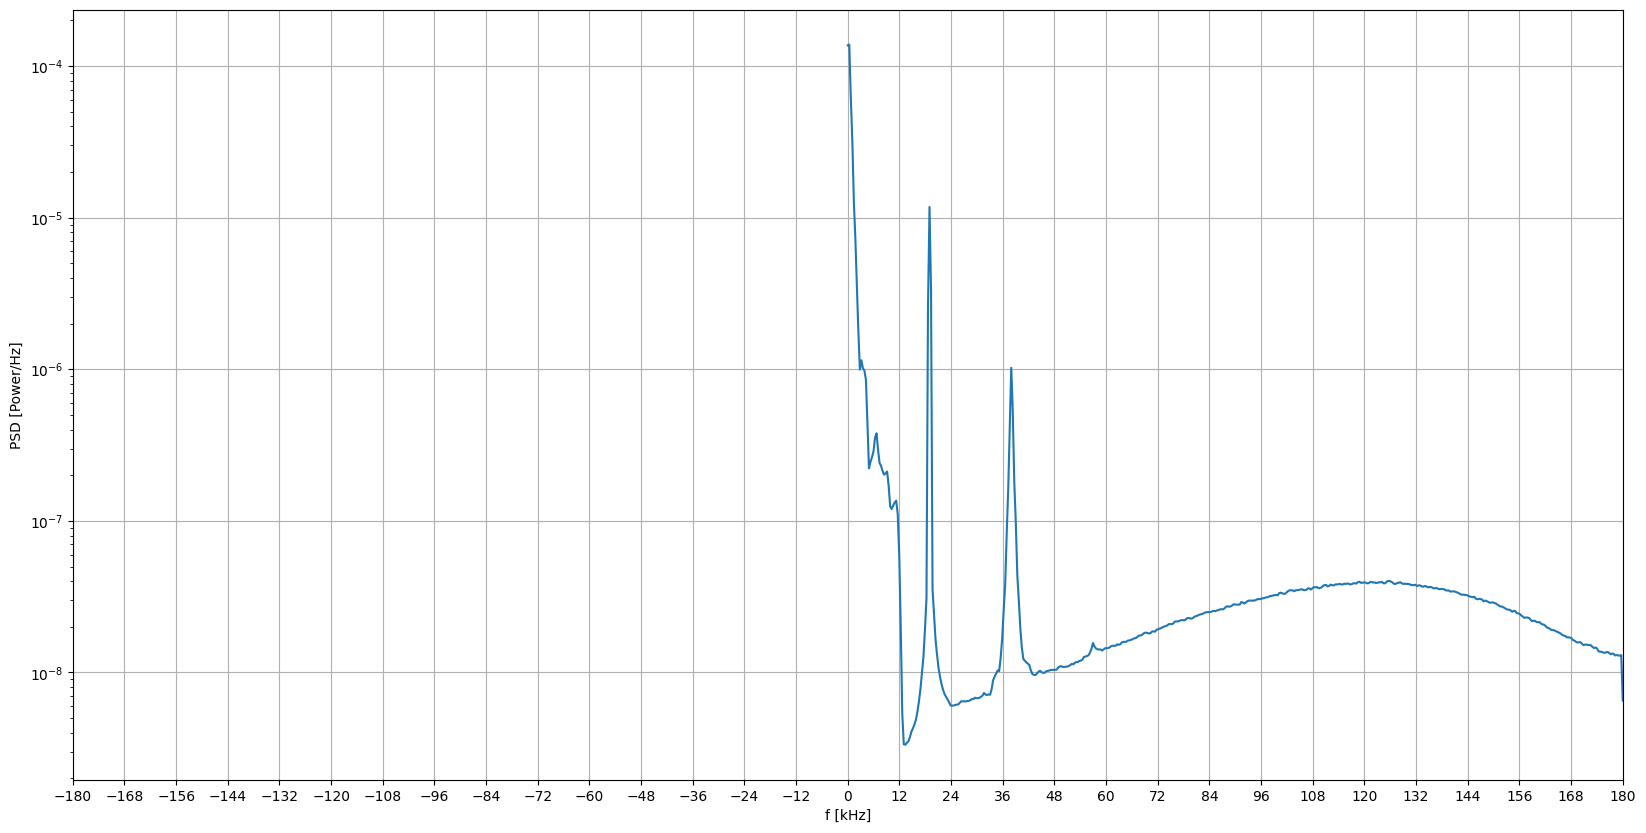

In [11]:
welch(phase_diff, n_rate)

In [12]:
phase_diff_dec = decimate(phase_diff, 5)

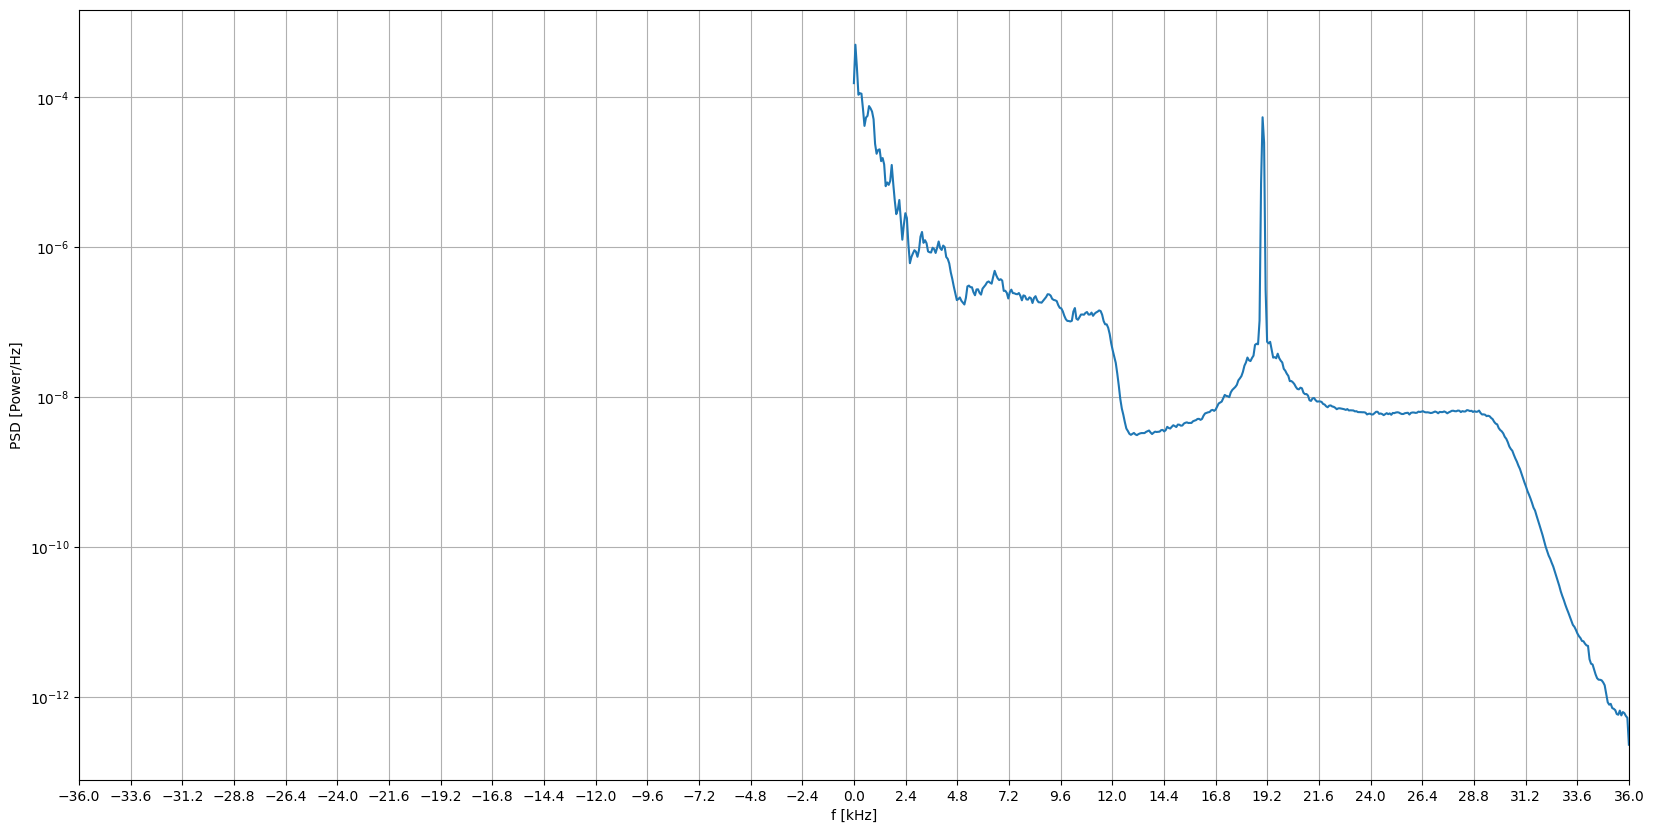

In [13]:
welch(phase_diff_dec, n_rate / 5) 

In [14]:
wavfile.write('farts.wav', 60000, phase_diff_dec / np.abs(phase_diff_dec).max())

So this is a success: play with `play -r 60k -e float -b 64 farts.wav` command. It seems (seen in Welch above too) that there is just very low signal level (very farty audio - but e.g. "wszystkich których" is intelligible), I wonder why.

### De-emphasis spectrum

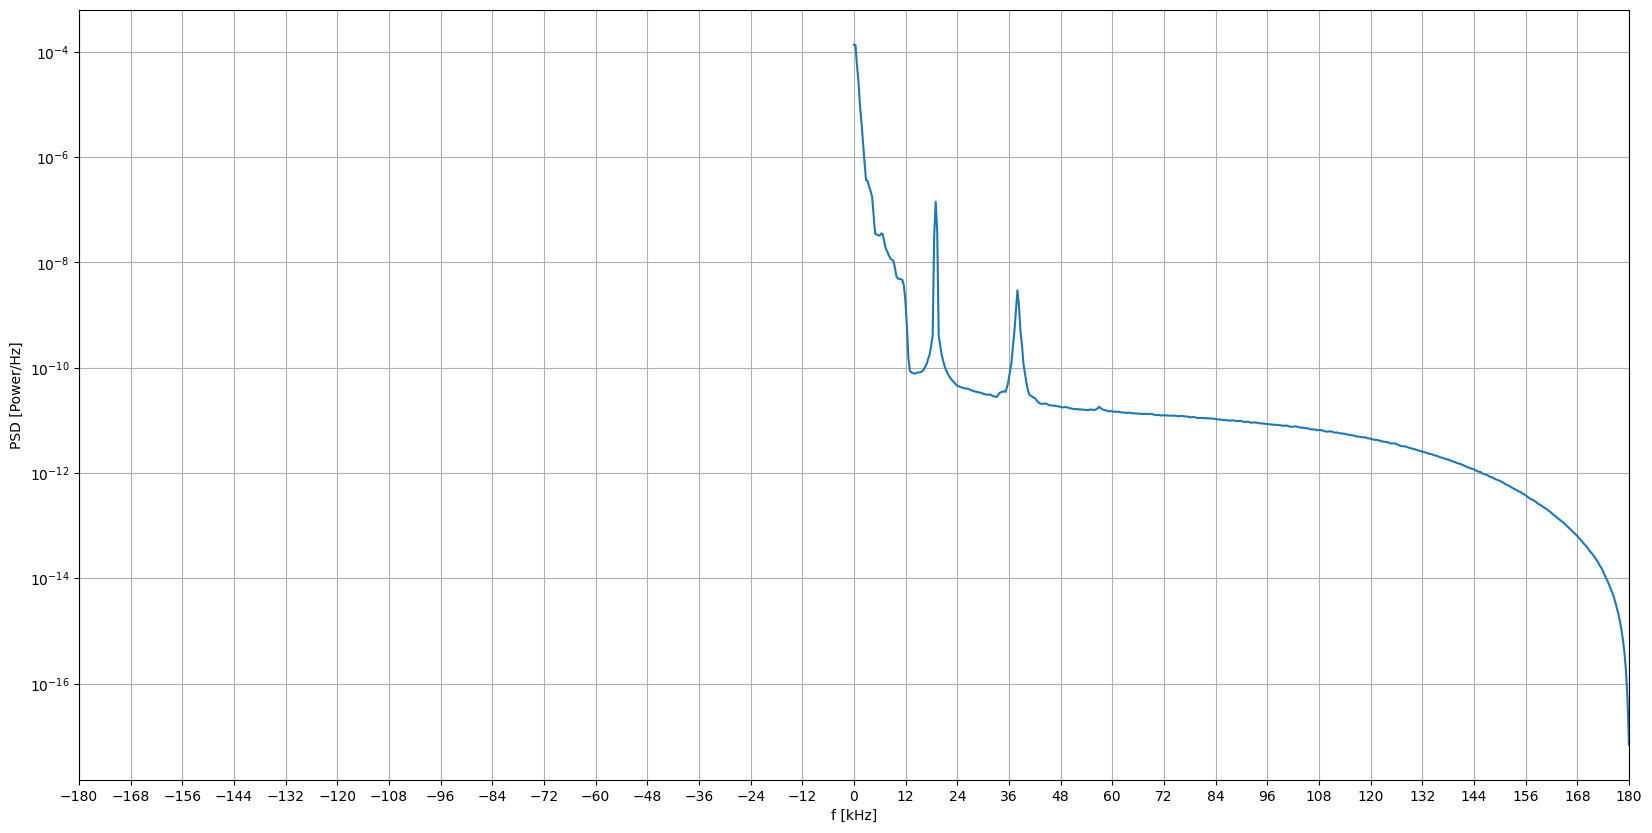

In [15]:
from scipy.signal import bilinear, lfilter
bz, az = bilinear(1, [75e-6, 1], fs=n_rate)
phase_diff_deemp = lfilter(bz, az, phase_diff)
welch(phase_diff_deemp, n_rate)

### From RTL (no offset tuning?)

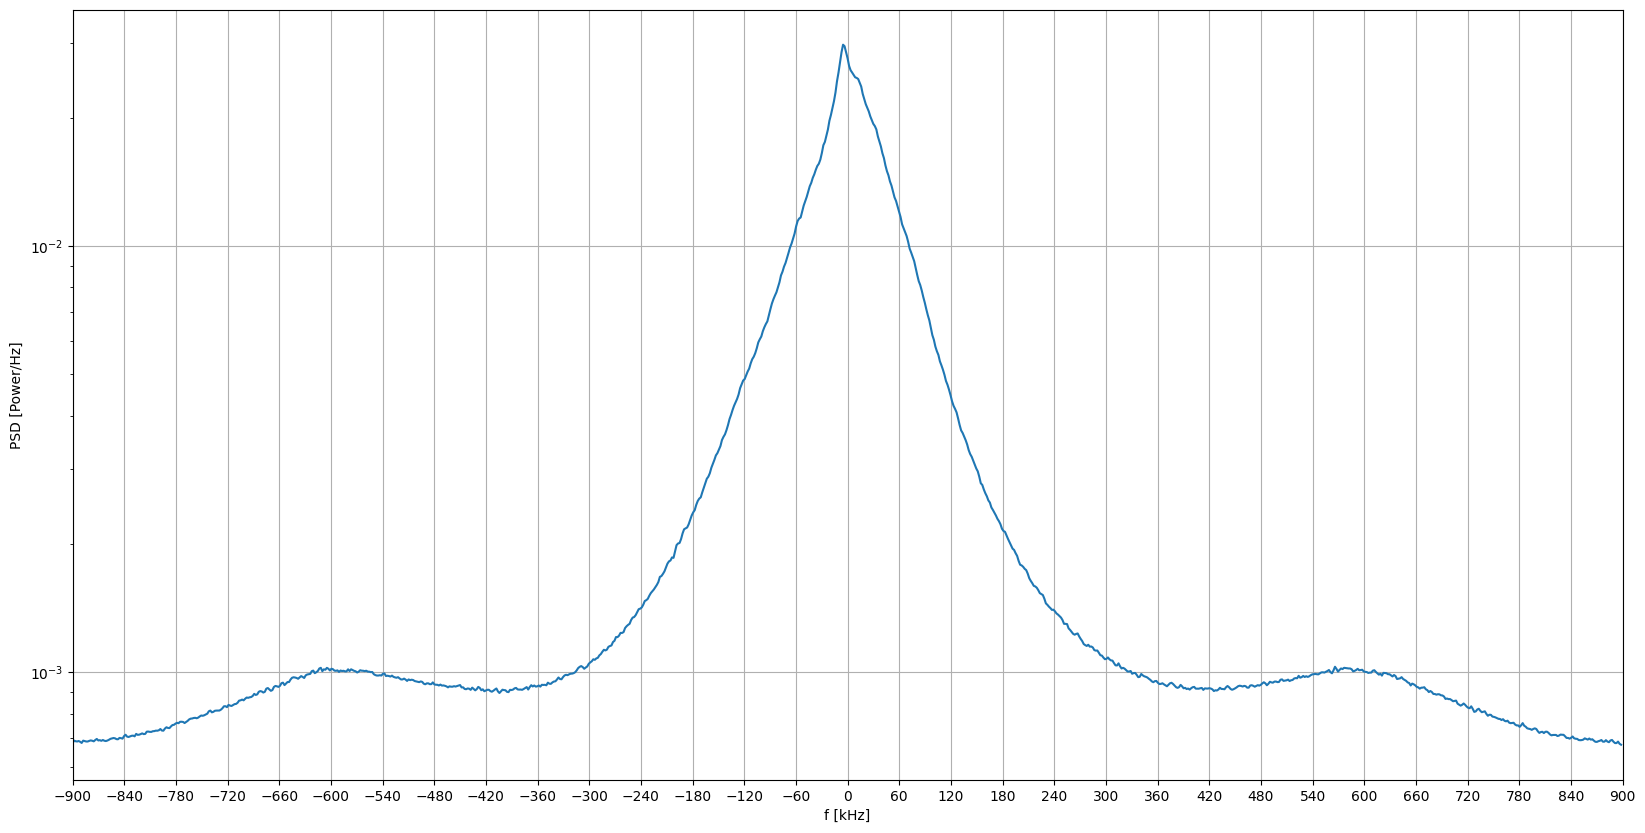

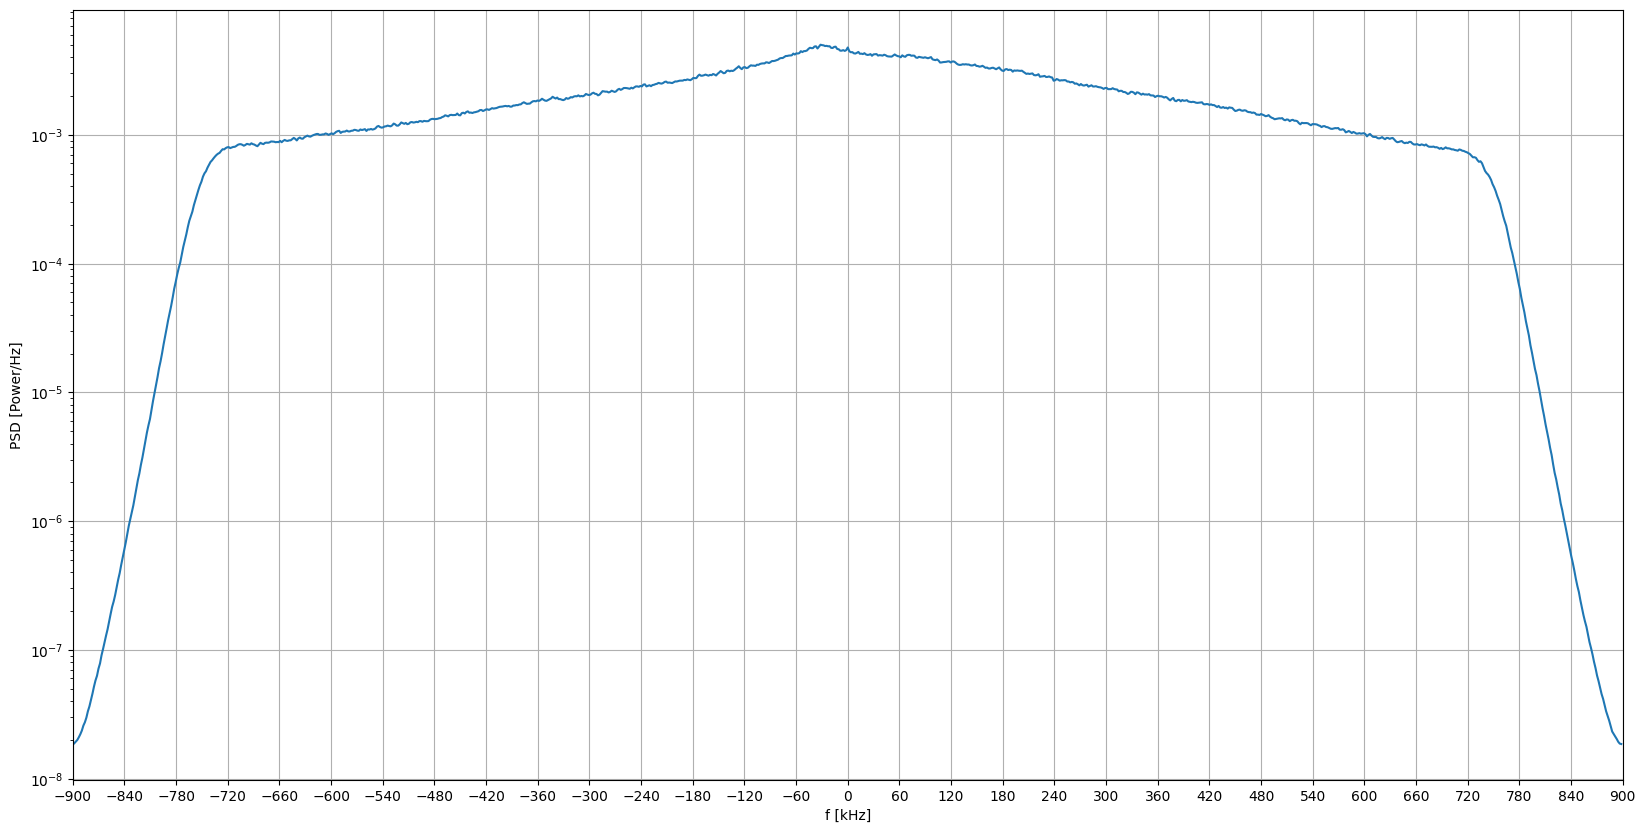

In [16]:
iq_samples_rtl = read_iq('data/102_7_rtl_sdr.raw')
welch(iq_samples_rtl, 1800000)
dec_iq_samples_rtl = decimate(iq_samples_rtl, 6)
welch(dec_iq_samples_rtl, 1800000)

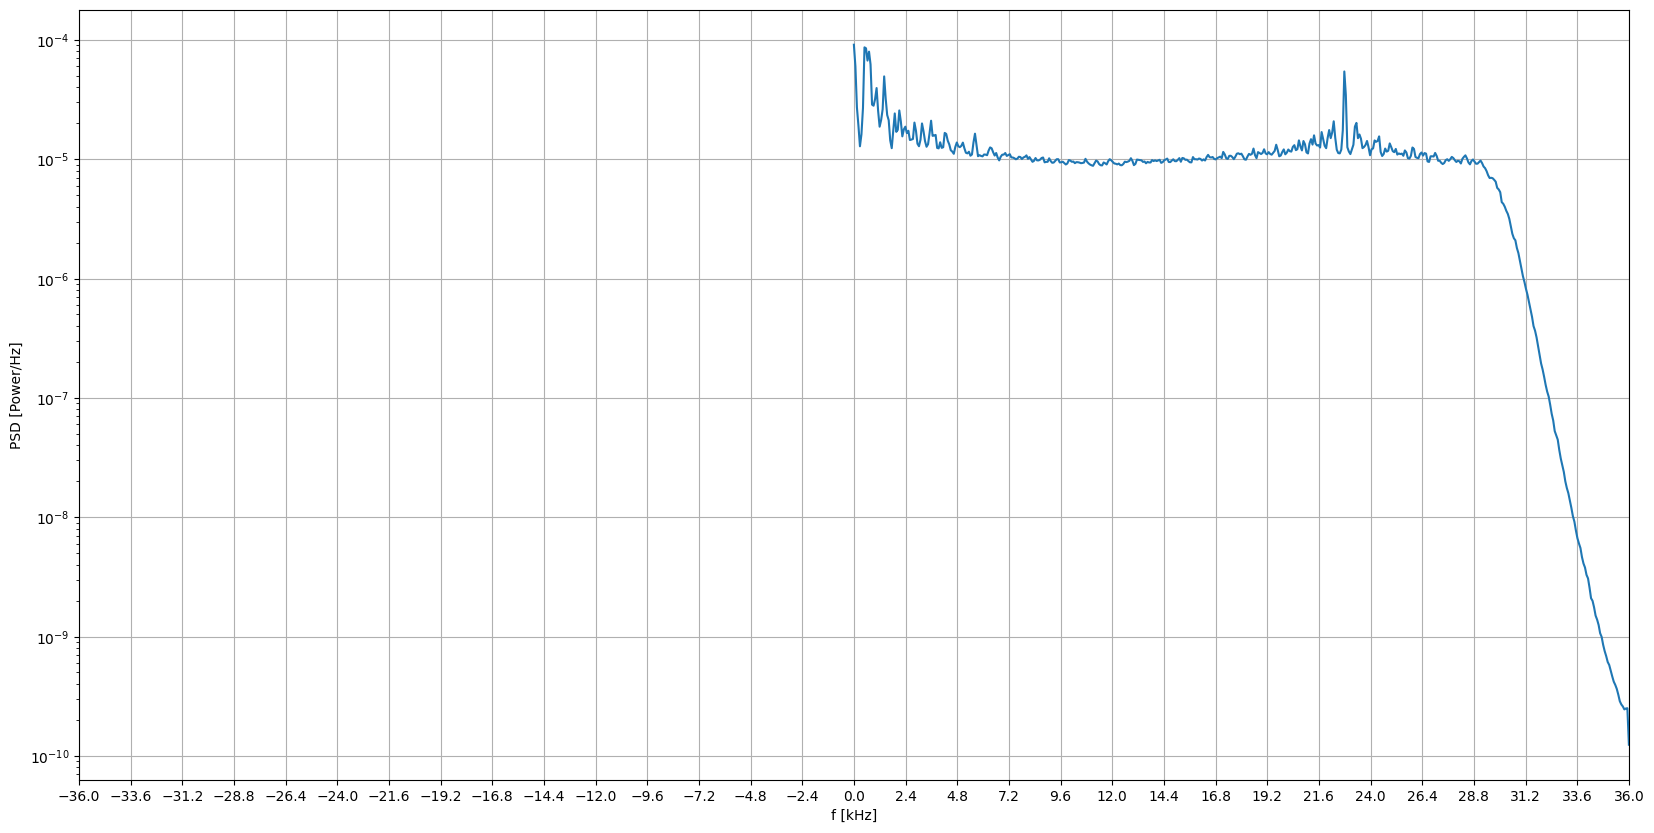

In [17]:
phase_diff_rtl = np.angle(dec_iq_samples_rtl[1:] * np.conj(dec_iq_samples_rtl[:-1]))
phase_diff_rtl_dec = decimate(phase_diff_rtl, 5)
welch(phase_diff_rtl_dec, n_rate / 5)

### Phase derivative with $atan$ derivative formula

In [18]:
xq, xi = np.imag(dec_iq_samples), np.real(dec_iq_samples)
d_xq, d_xi = np.diff(xq, prepend=xq[0]), np.diff(xi, prepend=xi[0])
phase_diff2 = (xi * d_xq - xq * d_xi) / (xq ** 2 + xi ** 2)

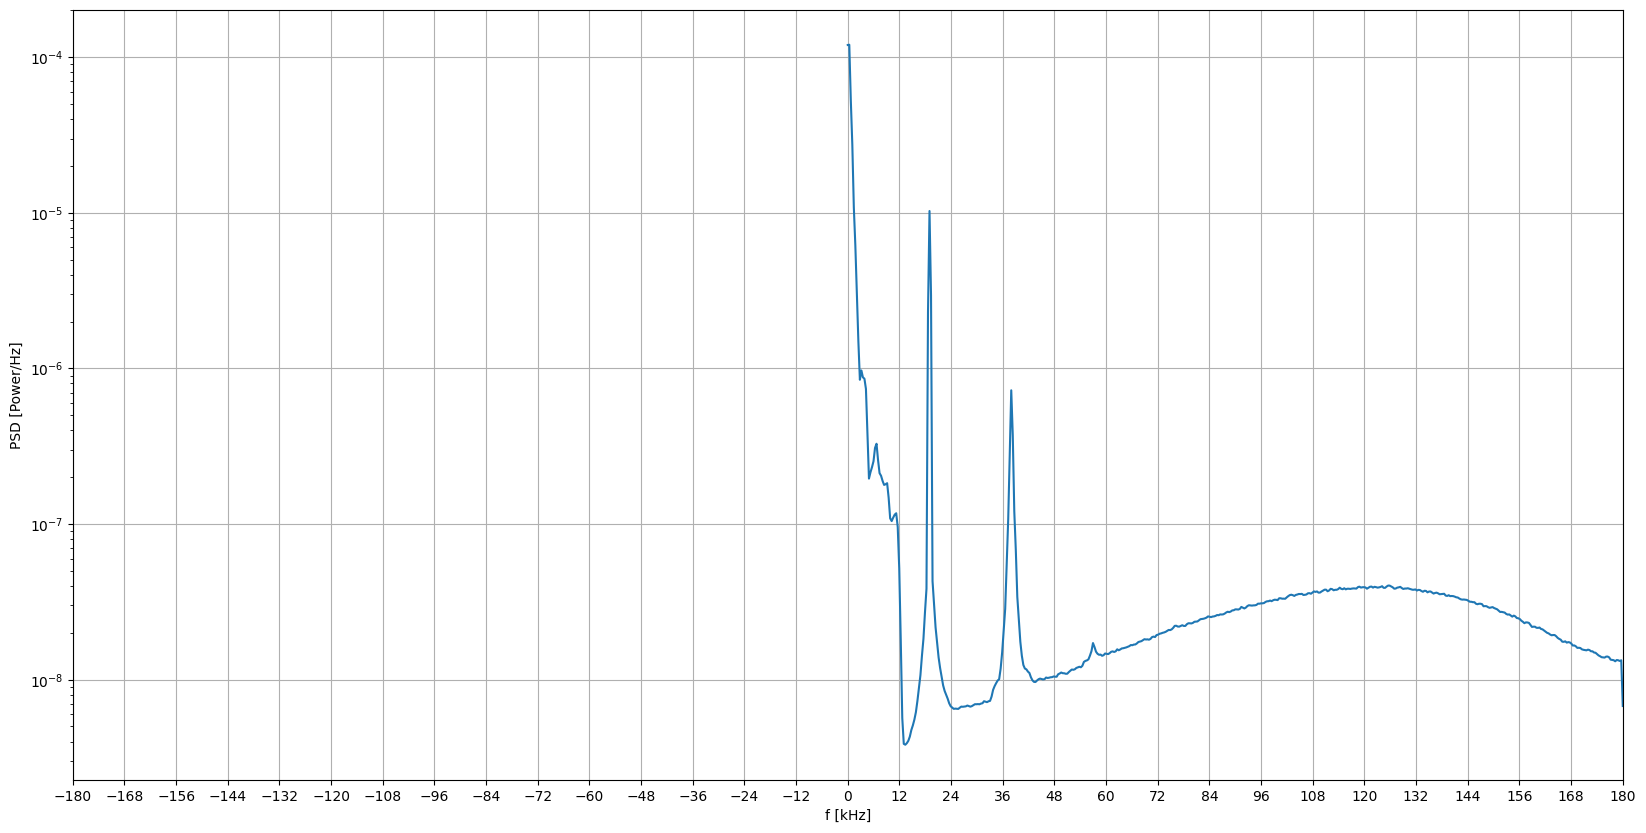

In [19]:
welch(phase_diff2, n_rate) 

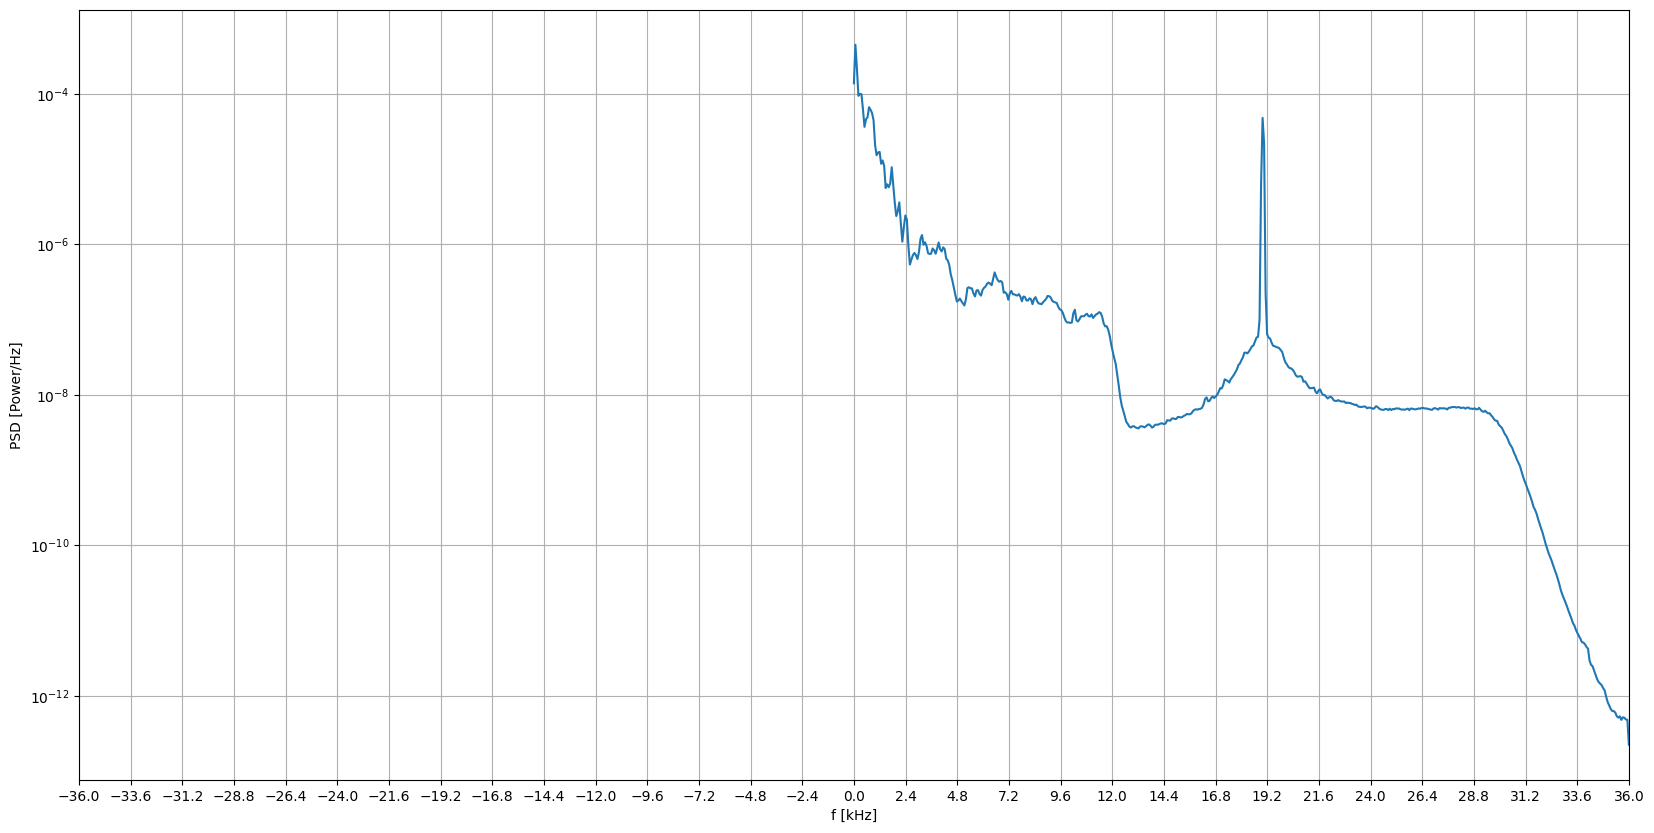

In [20]:
phase_diff2_dec = decimate(phase_diff2, 5)
welch(phase_diff2_dec, n_rate / 5)

In [21]:
wavfile.write('farts2.wav', 60000, phase_diff2_dec / np.abs(phase_diff2_dec).max())

This is just constant low-level hiss. So previous demodulation approach worked better!

### TODO
1. De-emphasis filter (attenuates high frequencies)?
2. Tune to other frequency and do frequency shift to avoid DC spike?
3. Check other samples for SNR. Other sampling rate?